# Case Study: Zeeguu/API
- Backend of a web application that supports [free reading in foreign languages](https://zeeguu.org)
- Open source [repository on GH](https://github.com/zeeguu/API/)

## Table of conentents
1. [Basic Data Gathering](#basic-data-gathering)
    1. [Extract dependencies](#extract-dependencies)
    2. [Visualize](#Visualize)
2. [Abstraction](#Abstraction)
3. [Evolution](#Evolution)
4. [Dynamic Analysis](#dynamic-analysis)



## Basic Data Gathering

- extracting basic dependencies between python modules
- every .py file is called a module in Python
- direct relationship between file name and module name
  - file: `./zeeguu_core/model/user.py` <==>
  - module: `zeeguu_core.model.User`


In [2]:
# Credit: https://colab.research.google.com/drive/1oe_TV7936Zmmzbbgq8rzqFpxYPX7SQHP#scrollTo=Njkjj4fzUV2E
# Installing Required Dependencies
import sys
sys.version
!{sys.executable} -m pip install gitpython
!{sys.executable} -m pip install pyvis

In [10]:
# Adopted from: https://colab.research.google.com/drive/1oe_TV7936Zmmzbbgq8rzqFpxYPX7SQHP#scrollTo=Njkjj4fzUV2E
import os
from git import Repo

# Current Working Directory
cwd = os.getcwd()
print(cwd)

# Code location
CODE_ROOT_FOLDER=f"/Users/andreaskongstad/Developer/PycharmProjects/architectural-reconstruction/data/zeeguu-api/"

# Clone the repository
if not os.path.exists(CODE_ROOT_FOLDER):
  Repo.clone_from("https://github.com/zeeguu/api", CODE_ROOT_FOLDER)



/Users/andreaskongstad/Developer/PycharmProjects/architectural-reconstruction


In [4]:
# Count absolute lines of code and number of files 
!cd {CODE_ROOT_FOLDER} && git ls-files | grep '\.py$' | xargs wc -l | grep total
!cd {CODE_ROOT_FOLDER} && git ls-files | grep "\.py$" | wc -l

   21206 total
     278


In [5]:
# helpers
def file_path(file_name):
    return f"{CODE_ROOT_FOLDER}{file_name}"


def module_name_from_file_path(full_path):
    """
    ../core/model/user.py -> zeeguu.core.model.user
    """
    file_name = full_path[len(CODE_ROOT_FOLDER):]
    file_name = file_name.replace("/__init__.py","")
    file_name = file_name.replace("/",".")
    file_name = file_name.replace(".py","")
    return file_name

File_Name = "zeeguu/core/model/user.py"
print(file_path(File_Name))
assert file_path(File_Name) == "/Users/andreaskongstad/Developer/PycharmProjects/architectural-reconstruction/data/zeeguu-api/zeeguu/core/model/user.py"
assert module_name_from_file_path(file_path(File_Name)) == "zeeguu.core.model.user"


def module_name_from_rel_path(full_path):

    # e.g. ../core/model/user.py -> zeeguu.core.model.user

    file_name = full_path.replace("/__init__.py","")
    file_name = file_name.replace("/",".")
    file_name = file_name.replace(".py","")
    return file_name

assert ("tools.migrations.teacher_dashboard_migration_1.upgrade" == module_name_from_rel_path("tools/migrations/teacher_dashboard_migration_1/upgrade.py"))
assert ("zeeguu.api") == module_name_from_rel_path("zeeguu/api/__init__.py")


  

/Users/andreaskongstad/Developer/PycharmProjects/architectural-reconstruction/data/zeeguu-api/zeeguu/core/model/user.py


### AST based parsing

In [6]:
import ast
from collections import defaultdict


def parse_imports(file):
    with open(file) as f:
        tree = ast.parse(f.read(), filename=file)
    
    imports = set() # all imported modules
    import_total_function_calls = defaultdict(int) # total calls to functions in imported modules
    import_distinct_function_calls = set() # unique calls to functions in imported modules
    function_to_module = {} # alias to module mapping
    
    try:
        for node in ast.walk(tree):
            match node:
                case ast.Import(names=names ):
                    for alias in names:
                        imports.add(alias.name)
                
                case ast.ImportFrom(module=module, names=names):
                    # What if module == .?
                    if module == None:
                        #imports.add(".") Internal imports. Disregard for now
                        continue
                    
                    imports.add(module)
                     
                    for alias in names:
                        function_to_module[alias.name] = module + "." + alias.name
            
                        
                case ast.Call(func=ast.Attribute(value=ast.Name(id=id), attr=attr), args=args, keywords=keywords):
                    if id in function_to_module:
                        import_total_function_calls[f"{function_to_module[id]}.{attr}"] += 1
                        import_distinct_function_calls.add(f"{function_to_module[id]}.{attr}")
                        
    except Exception as e:
        print(f"Error in {file}: {e}")
        print(f"Module: {module}")
        print(f"Alias: {alias.name}")
                    

    return imports, import_total_function_calls, import_distinct_function_calls


print(parse_imports(file_path('zeeguu/core/model/unique_code.py')))
assert parse_imports(file_path('zeeguu/core/model/unique_code.py'))[0] == {'datetime', 'zeeguu.core', 'zeeguu.core.model', 'sqlalchemy', 'random'}
print(parse_imports(file_path('zeeguu/api/endpoints/user_articles.py')))


({'sqlalchemy', 'datetime', 'zeeguu.core', 'random', 'zeeguu.core.model'}, defaultdict(<class 'int'>, {'zeeguu.core.model.db.Column': 4, 'zeeguu.core.model.db.String': 2, 'datetime.datetime.now': 1, 'sqlalchemy.func.lower': 1}), {'zeeguu.core.model.db.String', 'datetime.datetime.now', 'sqlalchemy.func.lower', 'zeeguu.core.model.db.Column'})
({'zeeguu.api.utils.json_result', 'flask', 'zeeguu.api.utils.route_wrappers', 'zeeguu.core.model', 'zeeguu.core.content_recommender'}, defaultdict(<class 'int'>, {'zeeguu.core.model.PersonalCopy.all_for': 1, 'zeeguu.core.model.UserArticle.user_article_info': 3, 'zeeguu.core.model.UserArticle.all_starred_and_liked_articles_of_user_info': 1}), {'zeeguu.core.model.UserArticle.all_starred_and_liked_articles_of_user_info', 'zeeguu.core.model.UserArticle.user_article_info', 'zeeguu.core.model.PersonalCopy.all_for'})


### Extract dependencies and visalize
To do that we iterate over all the python files with the help of the Path.rglob function from pathlib
And we create a network with the help of the networkx package.Visualize

In [17]:
# TODO: Add dependency data on hover
# TODO: Add coloration depending on node level
import pyvis.network as Network
import matplotlib.pyplot as plt
from pathlib import Path
import networkx as nx

def dependencies_digraph(code_root_folder):
    files = Path(code_root_folder).rglob("*.py")

    G = nx.DiGraph()

    for file in files:
        file_path = str(file)

        source_module = module_name_from_file_path(file_path)

        if source_module not in G.nodes:
            G.add_node(source_module)

        imports, _, _ = parse_imports(file_path)
        for target_module in imports:

            G.add_edge(source_module, target_module)
            # print(module_name + "=>" + each + ".")

    return G

# a function to draw a graph
def draw_graph_plt(G, size, **args):
    plt.figure(figsize=size)
    nx.draw(G, **args)
    plt.show()
    
def draw_graph_pyvis(G, size, output_file, **args):
    h, w = size
    g = Network.Network(height=h, width=w,notebook=True, cdn_resources='in_line', **args) 
    g.from_nx(G)
    g.barnes_hut()
    #g.toggle_physics(True)
    g.show(output_file)

def draw_graph_pyvis_example():
    G = nx.complete_graph(5)
    draw_graph_pyvis(G, (500, 500), "example.html", bgcolor="#222222", font_color="white")   
    
    


In [16]:
# Looking at the directed graph
DG = dependencies_digraph(CODE_ROOT_FOLDER)
draw_graph_pyvis(DG, (1000,1000), "draw_all.html", bgcolor="#222222", font_color="white")
# draw_graph_plt(DG, (10,10), with_labels=True, node_size=1000, font_size=10)

/Users/andreaskongstad/Developer/PycharmProjects/architectural-reconstruction/data/zeeguu-api/zeeguu/core/model/starred_article.py:71: SyntaxWarning: invalid escape sequence '\ '
  """
/Users/andreaskongstad/Developer/PycharmProjects/architectural-reconstruction/data/zeeguu-api/zeeguu/core/model/article.py:28: SyntaxWarning: invalid escape sequence '\s'
  MULTIPLE_NEWLINES = re.compile("\n\s*\n")
/Users/andreaskongstad/Developer/PycharmProjects/architectural-reconstruction/data/zeeguu-api/zeeguu/core/language/strategies/word_rank_difficulty_estimator.py:63: SyntaxWarning: invalid escape sequence '\d'
  words = [w for w in words if re.search("\d", w) == None]
/Users/andreaskongstad/Developer/PycharmProjects/architectural-reconstruction/data/zeeguu-api/data/zeeguu-api/zeeguu/core/model/starred_article.py:71: SyntaxWarning: invalid escape sequence '\ '
  """
/Users/andreaskongstad/Developer/PycharmProjects/architectural-reconstruction/data/zeeguu-api/data/zeeguu-api/zeeguu/core/model/arti

draw_all.html


## Abstraction
What do we have now:
- System: zeeguu/api
- Source View: Modules & Dependencies
- Entities: .py files in the project
- Relationships: import statements between .py files

Plan: Abstraction methods
1. Folder hierarchy
2. Aggregate dependencies using metrics. (Sum of calls)
    - Total count of explicit low-level dependencies
    - Number of distinct explicit low-level dependencies
    - Network analysis to detect rank packages: Note (It should not be that hard, the networkx package supports various methods of network analysis, e.g. centrality, HITS, pagerank.)
3. Create different level graphs and pass them to OpenAI vision model

### Filter relevant modules

In [241]:

def relevant_module(module_name):
    """
    Define relevant modules
    """
    if "test" in module_name:
        return False
    if module_name.startswith("zeeguu"):
        return True


    return False

def dependencies_digraph(code_root_folder):
    files = Path(code_root_folder).rglob("*.py")

    G = nx.DiGraph()

    for file in files:
        file_path = str(file)

        source_module = module_name_from_file_path(file_path)
        if not relevant_module(source_module):
          continue

        if source_module not in G.nodes:
            G.add_node(source_module)
            
            

        imports, _, _ = parse_imports(file_path)
        for target_module in imports:

            if relevant_module(target_module):
              G.add_edge(source_module, target_module)


    return G

# Looking at the directed graph
DG = dependencies_digraph(CODE_ROOT_FOLDER)
# draw_graph(DG, (40,40), with_labels=True)

/Users/andreaskongstad/Developer/PycharmProjects/architectural-reconstruction/data/zeeguu-api/zeeguu/core/model/starred_article.py:71: SyntaxWarning: invalid escape sequence '\ '
  """
/Users/andreaskongstad/Developer/PycharmProjects/architectural-reconstruction/data/zeeguu-api/zeeguu/core/model/article.py:28: SyntaxWarning: invalid escape sequence '\s'
  MULTIPLE_NEWLINES = re.compile("\n\s*\n")
/Users/andreaskongstad/Developer/PycharmProjects/architectural-reconstruction/data/zeeguu-api/zeeguu/core/language/strategies/word_rank_difficulty_estimator.py:63: SyntaxWarning: invalid escape sequence '\d'
  words = [w for w in words if re.search("\d", w) == None]


### Basic Abstraction Using Hierarchical Module Structure & Naming Conventions

- abstracting the imports between the modules along the module hierarchy
- also taking into account naming conventions to filter out external modules

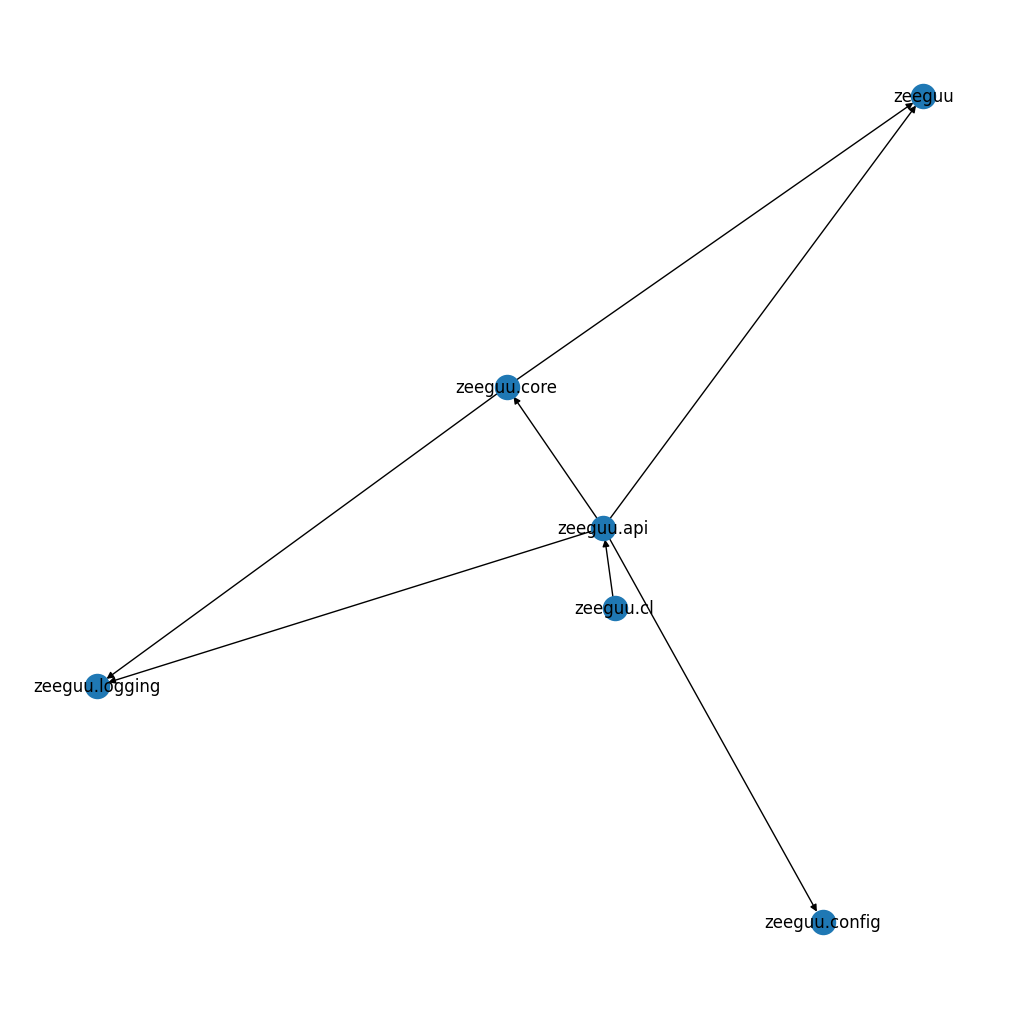

In [191]:
def top_level_package(module_name, depth=1):
    """Extract parent of module at depth"""
    components = module_name.split(".")
    return ".".join(components[:depth])

assert (top_level_package("zeeguu.core.model.util") == "zeeguu")
assert (top_level_package("zeeguu.core.model.util", 2) == "zeeguu.core")


def abstracted_to_top_level(G, depth=1):
    aG = nx.DiGraph()
    for each in G.edges():
        src = top_level_package(each[0], depth)
        dst = top_level_package(each[1], depth)

        if src != dst:
          aG.add_edge(src, dst)

    return aG

ADG = abstracted_to_top_level(DG, 2)
draw_graph(ADG, (10,10), with_labels=True)

### Abstraction with metrics

### Abstraction with network analysis

## Evolution
Plan:
1.  Churn Find hot code -- Most changed/imporant regions

2. Extract multiple complementary module views from your case study system
3. Ensure that your layouts are readable - limit the number of nodes in a view, use a different layout in networkx, or use a different library than networkx
4. Augment each of the previously obtained module views by mapping the above-computed churn metric on the color of a given node

In [ ]:
!{sys.executable} -m pip install pydriller

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 6.6 MB/s eta 0:00:00


In [ ]:
from pydriller import Repository
REPO_DIR = 'https://github.com/zeeguu/api'

In [ ]:
# for PyDriller to work we need to change directory to our local clone of the repo
%cd {CODE_ROOT_FOLDER}

/Users/andreaskongstad/Developer/PycharmProjects/architectural-reconstruction/data/zeeguu-api


In [ ]:
from collections import defaultdict
from pydriller import ModificationType

all_commits = list(Repository(REPO_DIR).traverse_commits())

def print_out_commit_details(commits):
    """ Usage: print_out_commit_details(all_commits[0:1])"""
    for commit in commits:
        print(commit)
        for each in commit.modified_files:
            print(f"{commit.author.name} {each.change_type} {each.filename}\n -{each.old_path}\n -{each.new_path}")


def commit_counts(all_commits):
    commit_counts = defaultdict(int)

    for commit in all_commits:
        for file in commit.modified_files:
            commit_counts[file.new_path] += 1

    return commit_counts


def commit_counts_better(all_commits):
    commit_counts = {}
    for commit in all_commits:
        for modification in commit.modified_files:

            new_path = modification.new_path
            old_path = modification.old_path

            try:
                if modification.change_type == ModificationType.RENAME:
                    commit_counts[new_path]=commit_counts.get(old_path,0)+1
                    commit_counts.pop(old_path)

                elif modification.change_type == ModificationType.DELETE:
                    commit_counts.pop(old_path, '')

                elif modification.change_type == ModificationType.ADD:
                    commit_counts[new_path] = 1

                else: # modification to existing file
                        commit_counts [old_path] += 1
            except Exception as e:
                print("something went wrong with: " + str(modification))
                pass
        return commit_counts
        
        

# sort by number of commits in decreasing order
commit_counts = commit_counts_better(all_commits)
sorted_commits = sorted(commit_counts.items(), key=lambda x: x[1], reverse=True)[:42]
# discussion: What is ("None", 103) ?

In [ ]:
def package_activity():
    package_activity = defaultdict(int)

    for path, count in commit_counts.items():
        if ".py" in str(path):
            l2_module = top_level_package(module_name_from_rel_path(path), 2)
            package_activity[l2_module] += count

    return package_activity

package_activity = package_activity()
sorted_sizes = sorted(package_activity.items(), key=lambda x: x[1], reverse=True)

In [ ]:
plt.figure(figsize=(7,7))
nx.draw_networkx(ADG, with_labels=True, node_size = sizes, node_color='r')
plt.show()


NameError: name 'nx' is not defined

<Figure size 700x700 with 0 Axes>

## Dynamic Analysis
Not as relavent for project.
Plan: Dont know if i will do this yet.

In [ ]:
import inspect

def methods_in_class(cls):
    """ Returns all the methods in a class """
    return [
		(name, object) 
		for (name, object) 
			in cls.__dict__.items() 
		if hasattr(object, '__call__')]
    
def log_decorator( function ):
    """ A decorator that logs the function on call """
    def decorated( *args, **kwargs ):
        print (f'I have been called: {function}')
        return function( *args,**kwargs )
    return decorated

def decorate_methods( cls, decorator ):
    """ Decorates all the methods in a class with a log_decorator"""
    methods = methods_in_class(cls)
    for name, method in methods:
	    setattr( cls, name, decorator ( method ))
    return cls


def caller(): 
	callee()

def callee():
    """ Prints the name of the calling function"""
    print(inspect.stack()[1].function)

caller()



In [ ]:
# Decoreate the user class:
from zeeguu.core.model import User
decorate_methods(User, log_decorator)

u= User.find_by_id(534)
u.bookmark_count()

# to see even further one can instrument also third party libraries!
from sqlalchemy.orm.query import Query
decorate_methods(Query, log_decorator)
